# BLADE DEMO


In this notebook, a demo of BLADE along with generation of simulation dataset is provided.

In addition to BLADE, the following two baseline methods are implemented:
- Non-negative least square (NNLS)
- Support Vector Regression (SVR)


### Load necessary modules


In [1]:
import sys, os
from Deconvolution.BLADE import Framework
import numpy as np
from numpy import transpose as t
import itertools
import pickle
from scipy.optimize import nnls
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.metrics import mean_squared_error as mse
import pandas as pd

# modules for visualization
import qgrid
from matplotlib import pyplot as plt
import seaborn as sns

## Generation of simulation data 

A simulation data is generated based on:
- number of cell types (`Ncells`)
- number of genes (`Ngenes`)
- number of samples (`Nsamples`)
- level of variability (`Noises`)

User can add or remove options by modifying the list variables below:

In [2]:
# training data
Ncells = [3]
Ngenes = [100]
Nsamples = [20]
Noises = [0.25, 0.5, 0.75, 1] 

A simulation dataset will be created for every possible combination of the above parameters.  
The script below will create `../simulationdata.pickle` that contains a dictionary object.

For each configuration of `Ncell`, `Ngene`, `Nsample` and `Noise`, the following elements are created:
- `F`: fraction of cell type (`Ncell` by `Nsample` matrix)
- `Mu`: average gene expression profile per cell type (signature in log-scale; `Ngene` by `Ncell` matrix)
- `Omega`: gene expression variability per cell type (`Ngene` by `Ncell` matrix)
- `X`: gene expression profile per cell type in each sample (`Nsample` by `Ngene` by `Ncell` multidimensional array)
- `Y`: bulk gene expression profile (log-scale; `Ngene` by `Nsample` matrix)



A rough illustration of the generation procedure follows:

1. Fraction of cell types (`F`) is generated from the Dirichlet distribution $F\sim\mathcal{D}(5)$)
2. Per cell type gene expression profiles (`Mu`) are generated from the normal distribution $Mu\sim\mathcal{N}(0, 2)$. The sampled gene expression profiles are in log-scale.
3. Given variation level (`Noise`), gene expression profile per cell type in each sample (`X`) is generated from the normal distribution $X\sim\mathcal{N}(\mu=Mu, \Omega=Noise)$
4. Bulk gene expression profile (`Y`) is calculated as follows: $Y = \log(F\cdot \exp(X)+1)$


In [3]:
simfile = '../simulationdata.pickle'
if not os.path.exists(simfile):
    Synthetic_data = dict()
else:
    Synthetic_data = pickle.load(open(simfile, 'rb'))

for Ncell, Ngene, Nsample, Noise in itertools.product(
    Ncells, Ngenes, Nsamples, Noises
            ):
    name = str(Ncell) +'_'+ str(Ngene) +'_'+ str(Nsample) +'_'+ str(Noise)
    
    if not name in list(Synthetic_data.keys()):
        F = np.random.dirichlet(np.ones(Ncell)*5, Nsample).transpose()
        Mu = np.random.normal(0, 2, size=(Ngene,Ncell))
        Omega = np.ones((Ngene,Ncell)) * Noise

        X = np.random.normal(Mu, Omega, size=(Nsample, Ngene, Ncell))
        Y = np.zeros((Ngene, Nsample))
        for i in range(Nsample):
            Y[:,i] = np.log(np.dot(np.exp(X[i,:,:]), F[:,i])+1)

    
        Synthetic_data[name] = {
            'Coef': F,
            'Mu' : Mu,
            'X' : X,
            'Y' : Y,
            'Omega' : Omega
        }
        
with open(simfile, 'wb') as fp:
    pickle.dump(Synthetic_data, fp, protocol=pickle.HIGHEST_PROTOCOL)

## Application of deconvolution methods

From here, we will apply the following three methods for further performance comparison:
1. BLADE (estimation of cellular fraction + group-mode/high-resolution-mode purification)
2. NNLS (estimation of fraction)
3. SVR followed by NNLS (estimation of fraction + group-mode purification) - similar to CIBERSORTx


### 1. Application of BLADE

These are the key parameters used in BLADE (note that there is default settings of these parameters, if not specified):
- Hyperparameters (`hyperpars`): `Alpha`, `Alpha0`, `Kappa0` and `SigmaY`, each of which can be defined as a list of options. BLADE takes an empirical Bayes approach to find the optimal parameter set given the all possible combinations. 
- `Nrep`: Number of repeat for evaluating each parameter configuration.
- `Nrepfinal`: Number of repeated optimizations for the final parameter set.
- `Njob`: Number of parallel jobs.

In [4]:
hyperpars = {
    'Alpha': [1, 10],
    'Alpha0': [0.1, 1, 5],
    'Kappa0': [1, 0.5, 0.1],
    'SigmaY': [0.3, 0.5, 1]
}

Nrep=3
Nrepfinal=10
Njob=10

Given the configuration above, BLADE is applied to each of the simulation dataset created previously.  

BLADE produce several outcomes:
- `final_obj`: final BLADE object with optimized variational parameters
- `best_obj`: BLADE object trained with the best parameter set found by the Empirical Bayes framework. Empirical Bayes framework is applied after selecting a subset of samples (5 samples; indicated by `Ind_sample` below), and thus the outcome contains only 5 samples. If `Nsample` <= 5, `final_obj` is identical to `best_obj`.
- `best_set`: Best parameter set defined by Empirical Bayes framework.
- `outs`: Outcome of BLADE for every possible combination of hyperparameters, used in the Empirical Bayes framework. 


In [5]:
for Ncell, Ngene, Nsample, Noise in itertools.product(
    Ncells, Ngenes, Nsamples, Noises,
                ):

    name = str(Ncell) +'_'+ str(Ngene) +'_'+ str(Nsample) +'_'+ str(Noise)
    outfile = '../data/BLADE_outcome_' + name + '.pickle'

    if not os.path.exists(outfile):
        print('creating ' + outfile)
        Y = np.exp(Synthetic_data[name]['Y']) - 1 #transform to the original scale
        mean = Synthetic_data[name]['Mu']
        sd = Synthetic_data[name]['Omega']
        
        final_obj, best_obj, best_set, outs = Framework(
            mean, sd, Y,
            Alphas=hyperpars['Alpha'], Alpha0s=hyperpars['Alpha0'], 
            Kappa0s=hyperpars['Kappa0'], SYs=hyperpars['SigmaY'],
            Nrep=Nrep, Njob=Njob, Nrepfinal=Nrepfinal)
        
        pickle.dump(
            {
                'final_obj': final_obj,
                'best_obj': best_obj,
                'best_set': best_set,
                'outs' : outs
            },
                open(outfile, 'wb')
        )

creating ../data/BLADE_outcome_3_100_20_0.25.pickle
all of 100 genes are used for optimization.
All samples are used during the optimization.
Initialization with Support vector regression


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    1.1s remaining:    4.5s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    1.2s remaining:    2.2s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    1.2s remaining:    0.7s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    1.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


No feature filtering is done (fsel = 0)


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   41.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   52.0s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done 160 out of 162 | elapsed:  2.8min remaining:    2.1s
[Parallel(n_jobs=10)]: Done 162 out of 162 | elapsed:  2.9min finished


Done optimization, elapsed time (min): 2.9809633175532024
creating ../data/BLADE_outcome_3_100_20_0.5.pickle
all of 100 genes are used for optimization.
All samples are used during the optimization.
Initialization with Support vector regression


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.0216s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


No feature filtering is done (fsel = 0)


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    7.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   14.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   25.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   36.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   50.4s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 160 out of 162 | elapsed:  2.2min remaining:    1.7s
[Parallel(n_jobs=10)]: Done 162 out of 162 | elapsed:  2.3min finished


Done optimization, elapsed time (min): 2.287643798192342
creating ../data/BLADE_outcome_3_100_20_0.75.pickle
all of 100 genes are used for optimization.
All samples are used during the optimization.
Initialization with Support vector regression


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.0276s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


No feature filtering is done (fsel = 0)


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    6.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    9.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   14.3s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   18.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   24.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   29.7s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   36.8s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   41.0s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   50.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   58.4s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 160 out of 162 | elapsed:  1.4min remaining:    1.0s
[Parallel(n_jobs=10)]: Done 162 out of 162 | elapsed:  1.4min finished


Done optimization, elapsed time (min): 1.4224974552790324
creating ../data/BLADE_outcome_3_100_20_1.pickle
all of 100 genes are used for optimization.
All samples are used during the optimization.
Initialization with Support vector regression


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.0170s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


No feature filtering is done (fsel = 0)


[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    4.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    6.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   10.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   14.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   19.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   24.7s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   30.5s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   35.9s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   43.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   50.0s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:   57.2s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 160 out of 162 | elapsed:  1.2min remaining:    0.9s
[Parallel(n_jobs=10)]: Done 162 out of 162 | elapsed:  1.4min finished


Done optimization, elapsed time (min): 1.357102922598521


### 2. Application of NNLS 

Non-negative least square is applied to obtain cellular fraction (`F`) using bulk gene expression profiles (`Y`) and gene expression signatures (`Mu`; average gene expression profiles per cell type). Note that NNLS should be applied to linear-scale data. The simulation data in `Synthetic_data` are in log-scale ($f(x)=\log(x+1)$ for `Y` and $f(x)=\log(x)$ for `Mu`), so they are transformed back to the linear scale.

In [6]:
for Ncell, Ngene, Nsample, Noise in itertools.product(
    Ncells, Ngenes, Nsamples, Noises,
                ):

    name = str(Ncell) +'_'+ str(Ngene) +'_'+ str(Nsample) +'_'+ str(Noise)
    outfile = '../data/NNLS_outcome_' + name + '.pickle'

    if not os.path.exists(outfile):
        
        print('creating ' + outfile)
        Y = np.exp(Synthetic_data[name]['Y'])-1 # transform back to linear scale
        Mu = np.exp(Synthetic_data[name]['Mu']) # transform back to linear scale
        
        NNLS_F = np.zeros(Synthetic_data[name]['Coef'].shape)
        for i in range(Nsample):
            NNLS_F[:,i] = nnls(Mu, Y[:,i])[0]
            NNLS_F[:,i] = NNLS_F[:,i]/np.sum(NNLS_F[:,i])
        
        pickle.dump(
            {
                'Fraction': NNLS_F
            },
            open(outfile, 'wb')
        )

creating ../data/NNLS_outcome_3_100_20_0.25.pickle
creating ../data/NNLS_outcome_3_100_20_0.5.pickle
creating ../data/NNLS_outcome_3_100_20_0.75.pickle
creating ../data/NNLS_outcome_3_100_20_1.pickle


### 3. Application of SVR followed by NNLS (SVR_NNLS)

SVR has been applied for estimation of cellular fractions (`Fraction`). As in CIBERSORT and CIBERSORTx, we used here Nu-SVR where the `Nu` controls the number of genes used in deconvolution. In CIBERSORTx, a sequencial approach is taken to also estimate gene expression profiles per cell type (both group-mode purification and high-resolution-mode purification). Here, we implement only the group-mode-purification (which we saved as `Signature`).

As in NNLS, both bulk gene expression profiles (Y) and gene expression sigantures (Mu; average gene expression profiles per cell type) should be transformed to linear-scale.


In [7]:
for Ncell, Ngene, Nsample, Noise in itertools.product(
    Ncells, Ngenes, Nsamples, Noises,
                ):

    name = str(Ncell) +'_'+ str(Ngene) +'_'+ str(Nsample) +'_'+ str(Noise)
    outfile = '../data/SVR_NNLS_outcome_' + name + '.pickle'

    if not os.path.exists(outfile):
        
        print('creating ' + outfile)
        Y = np.exp(Synthetic_data[name]['Y']) - 1
        Mu = np.exp(Synthetic_data[name]['Mu'])
   
        # estimate fraction
        SVRcoef = np.zeros((Ncell, Nsample))
        Selcoef = np.zeros((Ngene, Nsample))
        Nus = [0.25, 0.5, 0.75]
        for i in range(Nsample):
            sols = [NuSVR(kernel='linear', nu=nu).fit(Mu,Y[:,i]) for nu in Nus]
            RMSE = [mse(sol.predict(Mu), Y[:,i]) for sol in sols]
            Selcoef[sols[np.argmin(RMSE)].support_, i] = 1
            SVRcoef[:,i] = np.maximum(sols[np.argmin(RMSE)].coef_,0)
            SVRcoef[:,i] = SVRcoef[:,i]/np.sum(SVRcoef[:,i])
            
           
        # estimate per-cell expression
        NNLS_Sig = np.zeros((Ngene, Ncell))
        for g in range(Ngene):
            NNLS_Sig[g,:] = nnls(np.transpose(SVRcoef), Y[g,:])[0]
        
        pickle.dump(
            {
                'Fraction' : SVRcoef,
                'Signature': NNLS_Sig
             },
            open(outfile, 'wb')
         )

creating ../data/SVR_NNLS_outcome_3_100_20_0.25.pickle
creating ../data/SVR_NNLS_outcome_3_100_20_0.5.pickle
creating ../data/SVR_NNLS_outcome_3_100_20_0.75.pickle
creating ../data/SVR_NNLS_outcome_3_100_20_1.pickle


## Performance evaluation

We evaluated the performance for each data set in both per-cell and per-sample manner. In the function below (`measure_performance`), we implemented a function to collect the performances.

Specifically,
- Per cell type (`row_PerCell`):
 - `Cor_Fraction`: Pearson correlation coefficients of true (`true_f`) and estimated cellular fractions (`est_f`) per cell type across the samples.
 - `Cor_Signature`: Pearson correlation coefficients of true (`true_mean`) and estimated average gene expression profiles per cell type (Signatures; `est_mean`)
 - `Cor_HighRes`: Perason correaltion coefficients of true (`true_X`) and estimated gene expresion profile per cell type per sample (`est_X`). An average Pearson correlation per cell type is obtained.
 
- Summary (`row_Summary`):
 - Average performances of each measure in `row_PerCell` is obtained.

In [8]:
def measure_performance(true_f, true_mean, true_X, 
                        est_f, est_mean=None, est_X=None):
    Nsample, Ngene, Ncell = true_X.shape
    
    # group-mode purification performance
    if est_mean is not None:
        CorMean = [np.corrcoef(true_mean[:,i], est_mean[:,i], rowvar=True)[0,1] for i in range(Ncell)]
    else:
        CorMean = np.nan*np.zeros((Ncell))
    
    # high-resolution purification performance
    if est_X is not None:
        perf_highresCell = [
                np.mean(
                    [np.corrcoef(true_X[sample,:,cell], est_X[sample,:,cell])[0,1] for sample in range(Nsample)]
                ) for cell in range(Ncell)
            ]
        perf_highresSample = [
                np.mean(
                    [np.corrcoef(true_X[sample,:,cell], est_X[sample,:,cell])[0,1] for cell in range(Ncell)]
                ) for sample in range(Nsample)
            ]
    else:
        perf_highresCell = [np.nan]*Ncell
        perf_highresSample = [np.nan]*Nsample
    
    # Performance: per cell type
    CorsF = [np.corrcoef(true_f[i,:], est_f[i,:], rowvar=True)[0,1] for i in range(Ncell)]
    row_PerCell = pd.DataFrame(np.array((range(Ncell), CorsF, CorMean, perf_highresCell)).transpose(),
                    columns = ['CellType', 'Cor_Fraction', 'Cor_Signature', 'Cor_HighRes'])
        
    # Performance - summary
    row_Summary = pd.DataFrame([[np.mean(row_PerCell.Cor_Fraction), 
                                        np.mean(row_PerCell.Cor_Signature),
                                        np.mean(row_PerCell.Cor_HighRes)
                               ]],
            columns = ['Cor_Fraction', 'Cor_Signature', 'Cor_HighRes']
            )
    return (row_PerCell, row_Summary)

Using the function above, we will collect the performance metrics of the three methods.
For the evaluation, we need to obtain estimates of cellular fractions, average gene expression profile per cell type (Signature; only for BLADE and SVR_NNLS), and gene expression profile per cell type in each sample (only for BLADE).

Few specifics regarding the extraction of the estimates:

- BLADE
 - Fraction estimation: For each sample $i$ and cell type $t$, the fraction can be calculated from the optimized variational parameter $\beta_i^t$ as follows: $\frac{\beta_i^t}{\sum_k(\beta_i^k)}$. From the final object (`final_obj`), it can be calculated by the internal function `ExpF`.
 - Group-mode purification: Variational parameter $\nu_{ij}^t$ represents expression level of gene $j$ of cell type $t$ in sample $i$. Thus, average gene expression per cell type is: $\frac{1}{Nsample}\sum_i \nu_{ij}^t$.
 - High-resolution mode purification: we can use $\nu_{ij}^t$ as the estimate.

- NNLS
 - Fraction estimation: Regression coefficients stands for the fraction.
 - Group-mode purification: Not available
 - High-resolution-mode purification: Not available

- SVR_NNLS
 - Fraction estimation: Regression coefficients from SVR.
 - Group-mode purification: Regression coefficients from NNLS.
 - High-resolution-mode purification: Not available

In [9]:
outcome_PerCell = pd.DataFrame()
outcome_summary = pd.DataFrame()
                               
for Ncell, Ngene, Nsample, Noise in itertools.product(
    Ncells, Ngenes, Nsamples, Noises,
                ):

    name = str(Ncell) +'_'+ str(Ngene) +'_'+ str(Nsample) +'_'+ str(Noise)
    
    #Loading test data
    fraction = np.array(Synthetic_data[name]['Coef'])
    mean = np.array(Synthetic_data[name]['Mu'])
    X = np.array(Synthetic_data[name]['X'])
    
    # Load outcome
    BLADE = pickle.load(open('../data/BLADE_outcome_' + name + '.pickle', 'rb'))
    NNLS = pickle.load(open('../data/NNLS_outcome_' + name + '.pickle', 'rb'))
    SVR_NNLS = pickle.load(open('../data/SVR_NNLS_outcome_' + name + '.pickle', 'rb'))
    
    # Obtaining estimates from the three methods
    obj = BLADE['final_obj']
    
    outcomes = {
        'BLADE': {
            'Fraction': t(obj.ExpF(obj.Beta)), 
            'Signature': np.mean(obj.Nu, 0), #group mode purification
            'HighRes': obj.Nu                #highresolution mode purification
        },
        'NNLS' : {
            'Fraction': NNLS['Fraction'],
            'Signature': None, 'HighRes': None
        },
        'SVR_NNLS' : {
            'Fraction': SVR_NNLS['Fraction'],
            'Signature': np.log(SVR_NNLS['Signature']+0.0001),
            'HighRes': None
        }
    }
    
    # measure performance
    for method in outcomes:
        rowCell, rowSummary = \
            measure_performance(
                fraction, mean, X,
                outcomes[method]['Fraction'], outcomes[method]['Signature'], outcomes[method]['HighRes']
            )
        rowCell['method'], rowSummary['method'] = [method]*2
        rowCell['Ncell'], rowSummary['Ncell'] = [Ncell]*2
        rowCell['Ngene'], rowSummary['Ngene'] = [Ngene]*2
        rowCell['Nsample'], rowSummary['Nsample'] = [Nsample]*2
        rowCell['Noise'], rowSummary['Noise'] = [Noise]*2
        rowCell['dataset'], rowSummary['dataset'] = [name]*2
    
        # collect outcome
        outcome_PerCell = outcome_PerCell.append(rowCell)
        outcome_summary = outcome_summary.append(rowSummary)

## Visualization of outcome


### 1. Performance of cellular fraction estimation

We will first visualize the performance measure per cell type.
First of all, a boxplot can be created for each data set as below.

Text(0, 0.5, 'Pearson Correlation')

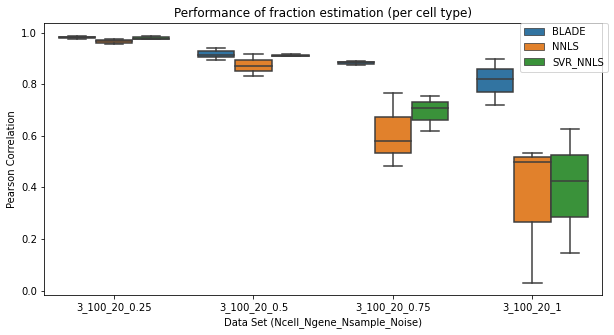

In [10]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(data = outcome_PerCell,
            y='Cor_Fraction', hue='method', x='dataset'
           )

ax.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
ax.set_title('Performance of fraction estimation (per cell type)')
ax.set_xlabel("Data Set (Ncell_Ngene_Nsample_Noise)")
ax.set_ylabel("Pearson Correlation")

Then, performance of each cell type can also be compared across the methods using a scatter plot.

(0.0, 1.0)

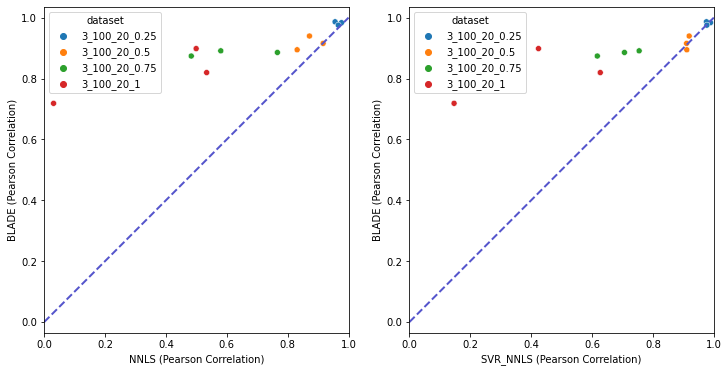

In [11]:
PerfMat = outcome_PerCell.pivot_table(values='Cor_Fraction', columns='method', index=['CellType','dataset'])
PerfMat.reset_index(inplace=True)
PerfMat.dataset = PerfMat.dataset.astype('category')

# plot_seaborn
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
ax = sns.scatterplot(data=PerfMat, y='BLADE', x='NNLS', hue='dataset')
ax.set_xlabel("NNLS (Pearson Correlation)")
ax.set_ylabel("BLADE (Pearson Correlation)")
plt.plot([0,1],[0,1], lw=2, color='#5555CC', linestyle='dashed')
plt.axis('equal')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.subplot(1,2,2)
ax = sns.scatterplot(data=PerfMat, y='BLADE', x='SVR_NNLS', hue='dataset')
plt.plot([0,1],[0,1], lw=2, color='#5555CC', linestyle='dashed')
ax.set_xlabel("SVR_NNLS (Pearson Correlation)")
ax.set_ylabel("BLADE (Pearson Correlation)")
plt.axis('equal')
plt.ylim(0, 1)
plt.xlim(0, 1)

Performance of fraction estimation can be also measured per sample.

### 2. Performance of gene expression purification

Performance for estimation of gene expression profiles per cell type can be compared.  
Group-mode purification is done by BLADE and SVR_NNLS.  

Text(0, 0.5, 'Pearson Correlation')

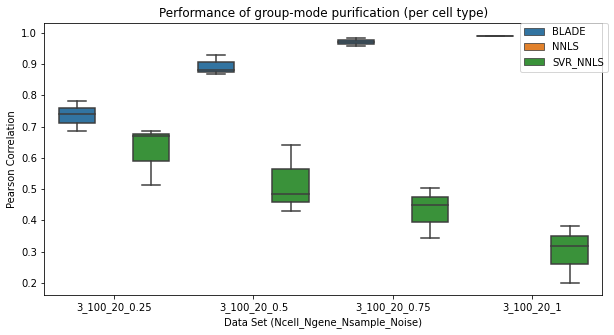

In [12]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(data = outcome_PerCell,
            y='Cor_Signature', hue='method', x='dataset'
           )

ax.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
ax.set_title("Performance of group-mode purification (per cell type)")
ax.set_xlabel("Data Set (Ncell_Ngene_Nsample_Noise)")
ax.set_ylabel("Pearson Correlation")

(0.0, 1.0)

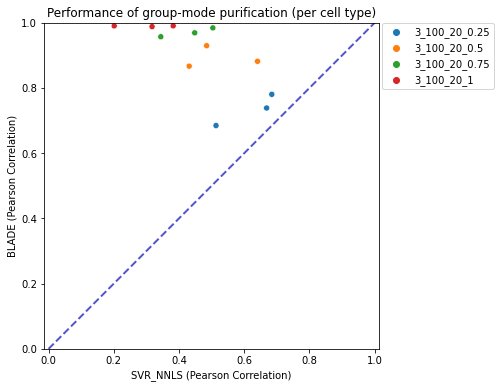

In [13]:
PerfMat = outcome_PerCell.pivot_table(values='Cor_Signature', columns='method', index=['CellType','dataset'])
PerfMat.reset_index(inplace=True)
PerfMat.dataset = PerfMat.dataset.astype('category')


plt.figure(figsize=(6,6))
ax = sns.scatterplot(data=PerfMat, y='BLADE', x='SVR_NNLS', hue='dataset')
ax.set_xlabel("SVR_NNLS (Pearson Correlation)")
ax.set_ylabel("BLADE (Pearson Correlation)")
ax.set_title('Performance of group-mode purification (per cell type)')
ax.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.plot([0,1],[0,1], lw=2, color='#5555CC', linestyle='dashed')
plt.axis('equal')
plt.ylim(0, 1)
plt.xlim(0, 1)

Now, we will assess performance of BLADE for high-resolution mode purification.  
The performance can be measure per cell type (average across the samples) and per sample (average across the cell types)

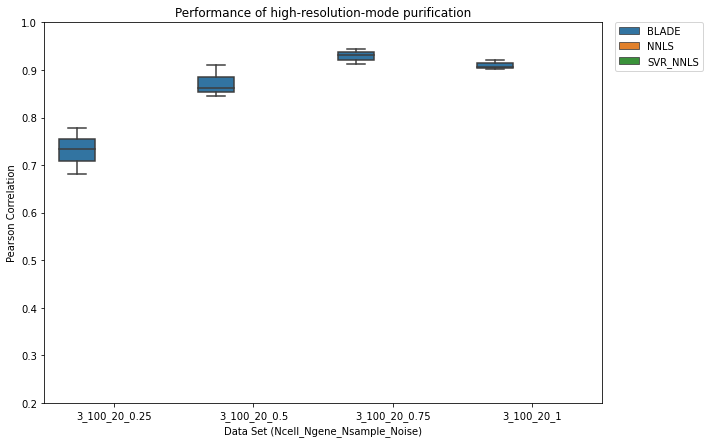

In [14]:
plt.figure(figsize=(10,7))

ax = sns.boxplot(data = outcome_PerCell,
            y='Cor_HighRes', hue='method', x='dataset'
           )

ax.set_title('Performance of high-resolution-mode purification')
ax.set_xlabel("Data Set (Ncell_Ngene_Nsample_Noise)")
ax.set_ylabel("Pearson Correlation")
plt.ylim(0.2, 1)
ax.legend(bbox_to_anchor=(1.18, 1),borderaxespad=0)


Average performance per dataset can also be checked in the table below:


In [15]:
qgrid_widget = qgrid.show_grid(outcome_summary, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…